# Fine Tuning Resnet 18 Focal Loss Clinic

Creamos una FocalLoss porque funciona bien con un dataset desbalanceado

In [48]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma

    def forward(self, logit, target):
        target = target.float()
        max_val = (-logit).clamp(min=0)
        loss = logit - logit * target + max_val + \
               ((-max_val).exp() + (-logit - max_val).exp()).log()

        invprobs = F.logsigmoid(-logit * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        if len(loss.size())==2:
            loss = loss.sum(dim=1)
        return loss.mean()

In [49]:
learner_focal = cnn_learner(data, models.resnet18, metrics=[error_rate,accuracy], pretrained='imagenet')
learner_focal.loss_fn = FocalLoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


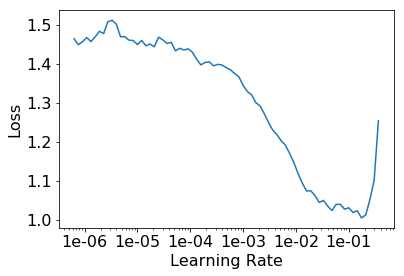

In [50]:
learner_focal.lr_find()
learner_focal.recorder.plot()

In [51]:
learner_focal.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.557760,0.271704,0.108247,0.891753,00:08
1,0.376310,0.198258,0.063574,0.936426,00:08
2,0.288913,0.145153,0.046392,0.953608,00:08
3,0.225698,0.128663,0.051546,0.948454,00:08
4,0.216832,0.143411,0.054983,0.945017,00:08


In [52]:
learner_focal.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.213341,0.114583,0.030928,0.969072,00:08
1,0.214867,0.118908,0.042955,0.957045,00:08
2,0.177350,0.090217,0.029210,0.970790,00:08
3,0.162929,0.087488,0.029210,0.970790,00:08


In [53]:
learner_focal.export('export_stage-1-18-Clinic_Focal_3_Classes')

learner_focal.unfreeze()
learner_focal.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.145804,0.082503,0.024055,0.975945,00:08
1,0.128225,0.069622,0.022337,0.977663,00:08
2,0.126373,0.080361,0.024055,0.975945,00:08
3,0.136300,0.063709,0.015464,0.984536,00:08


In [54]:
learner_focal.fit_one_cycle(4, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.210293,0.309859,0.091065,0.908935,00:09
1,0.164353,0.124138,0.046392,0.953608,00:08
2,0.103843,0.088987,0.030928,0.969072,00:08
3,0.081227,0.059377,0.022337,0.977663,00:08


In [55]:
learner_focal.fit_one_cycle(6, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.085210,0.057246,0.017182,0.982818,00:09
1,0.075645,0.055874,0.025773,0.974227,00:09
2,0.066939,0.051565,0.018900,0.981100,00:08
3,0.061092,0.050842,0.018900,0.981100,00:09
4,0.064465,0.049383,0.017182,0.982818,00:09
5,0.069803,0.049782,0.018900,0.981100,00:08


In [56]:
learner_focal.fit_one_cycle(4, max_lr=slice(1e-7))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.059482,0.050281,0.020619,0.979381,00:08
1,0.067708,0.051572,0.018900,0.981100,00:09
2,0.052934,0.048913,0.018900,0.981100,00:09
3,0.045932,0.053453,0.020619,0.979381,00:09


In [57]:
learner_focal.export('export_stage-2-18-Clinic_Focal_3_Classes')

interp = ClassificationInterpretation.from_learner(learner_focal)

interp.most_confused(min_val=2)

[('ATYPICAL_LYMPHOCYTE', 'VARIANT_LYMPHOCYTE', 4),
 ('ATYPICAL_LYMPHOCYTE', 'BLAST', 3),
 ('BLAST', 'VARIANT_LYMPHOCYTE', 3)]

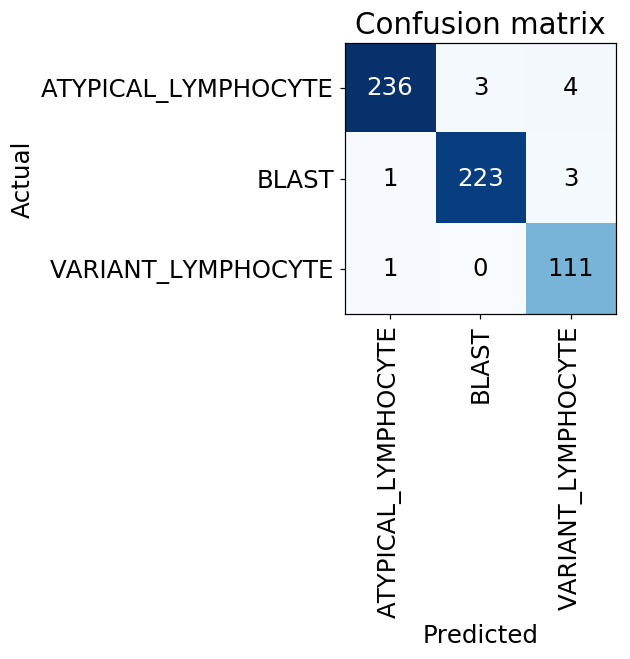

In [58]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=110)

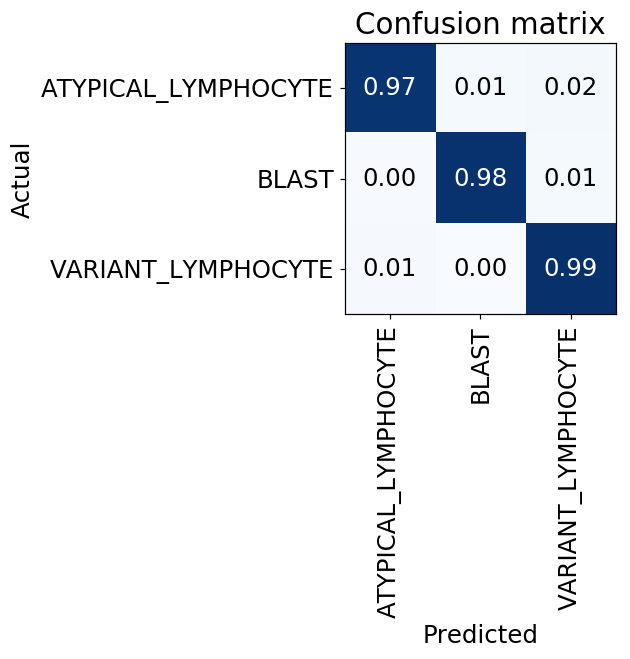

In [59]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=110, normalize=True)

In [72]:
learn_test_focal = load_learner( '/shared/Classification_Clinic_Balanced', 'export_stage-2-18-Clinic_Focal_3_Classes') 
learn_test_focal.data = data_test

In [73]:
metrics_valid_focal = learn_test_focal.validate(data_test.valid_dl)

In [74]:
valid_results_focal = dict(zip(['valid_loss', 'error_rate', 'accuracy'],
                         [metrics_valid_focal[0], metrics_valid_focal[1].item(),metrics_valid_focal[2].item()]))
pd.DataFrame(valid_results_focal, index = ['metrics'])

,valid_loss,error_rate,accuracy
metrics,0.0364,0.018939,0.981061


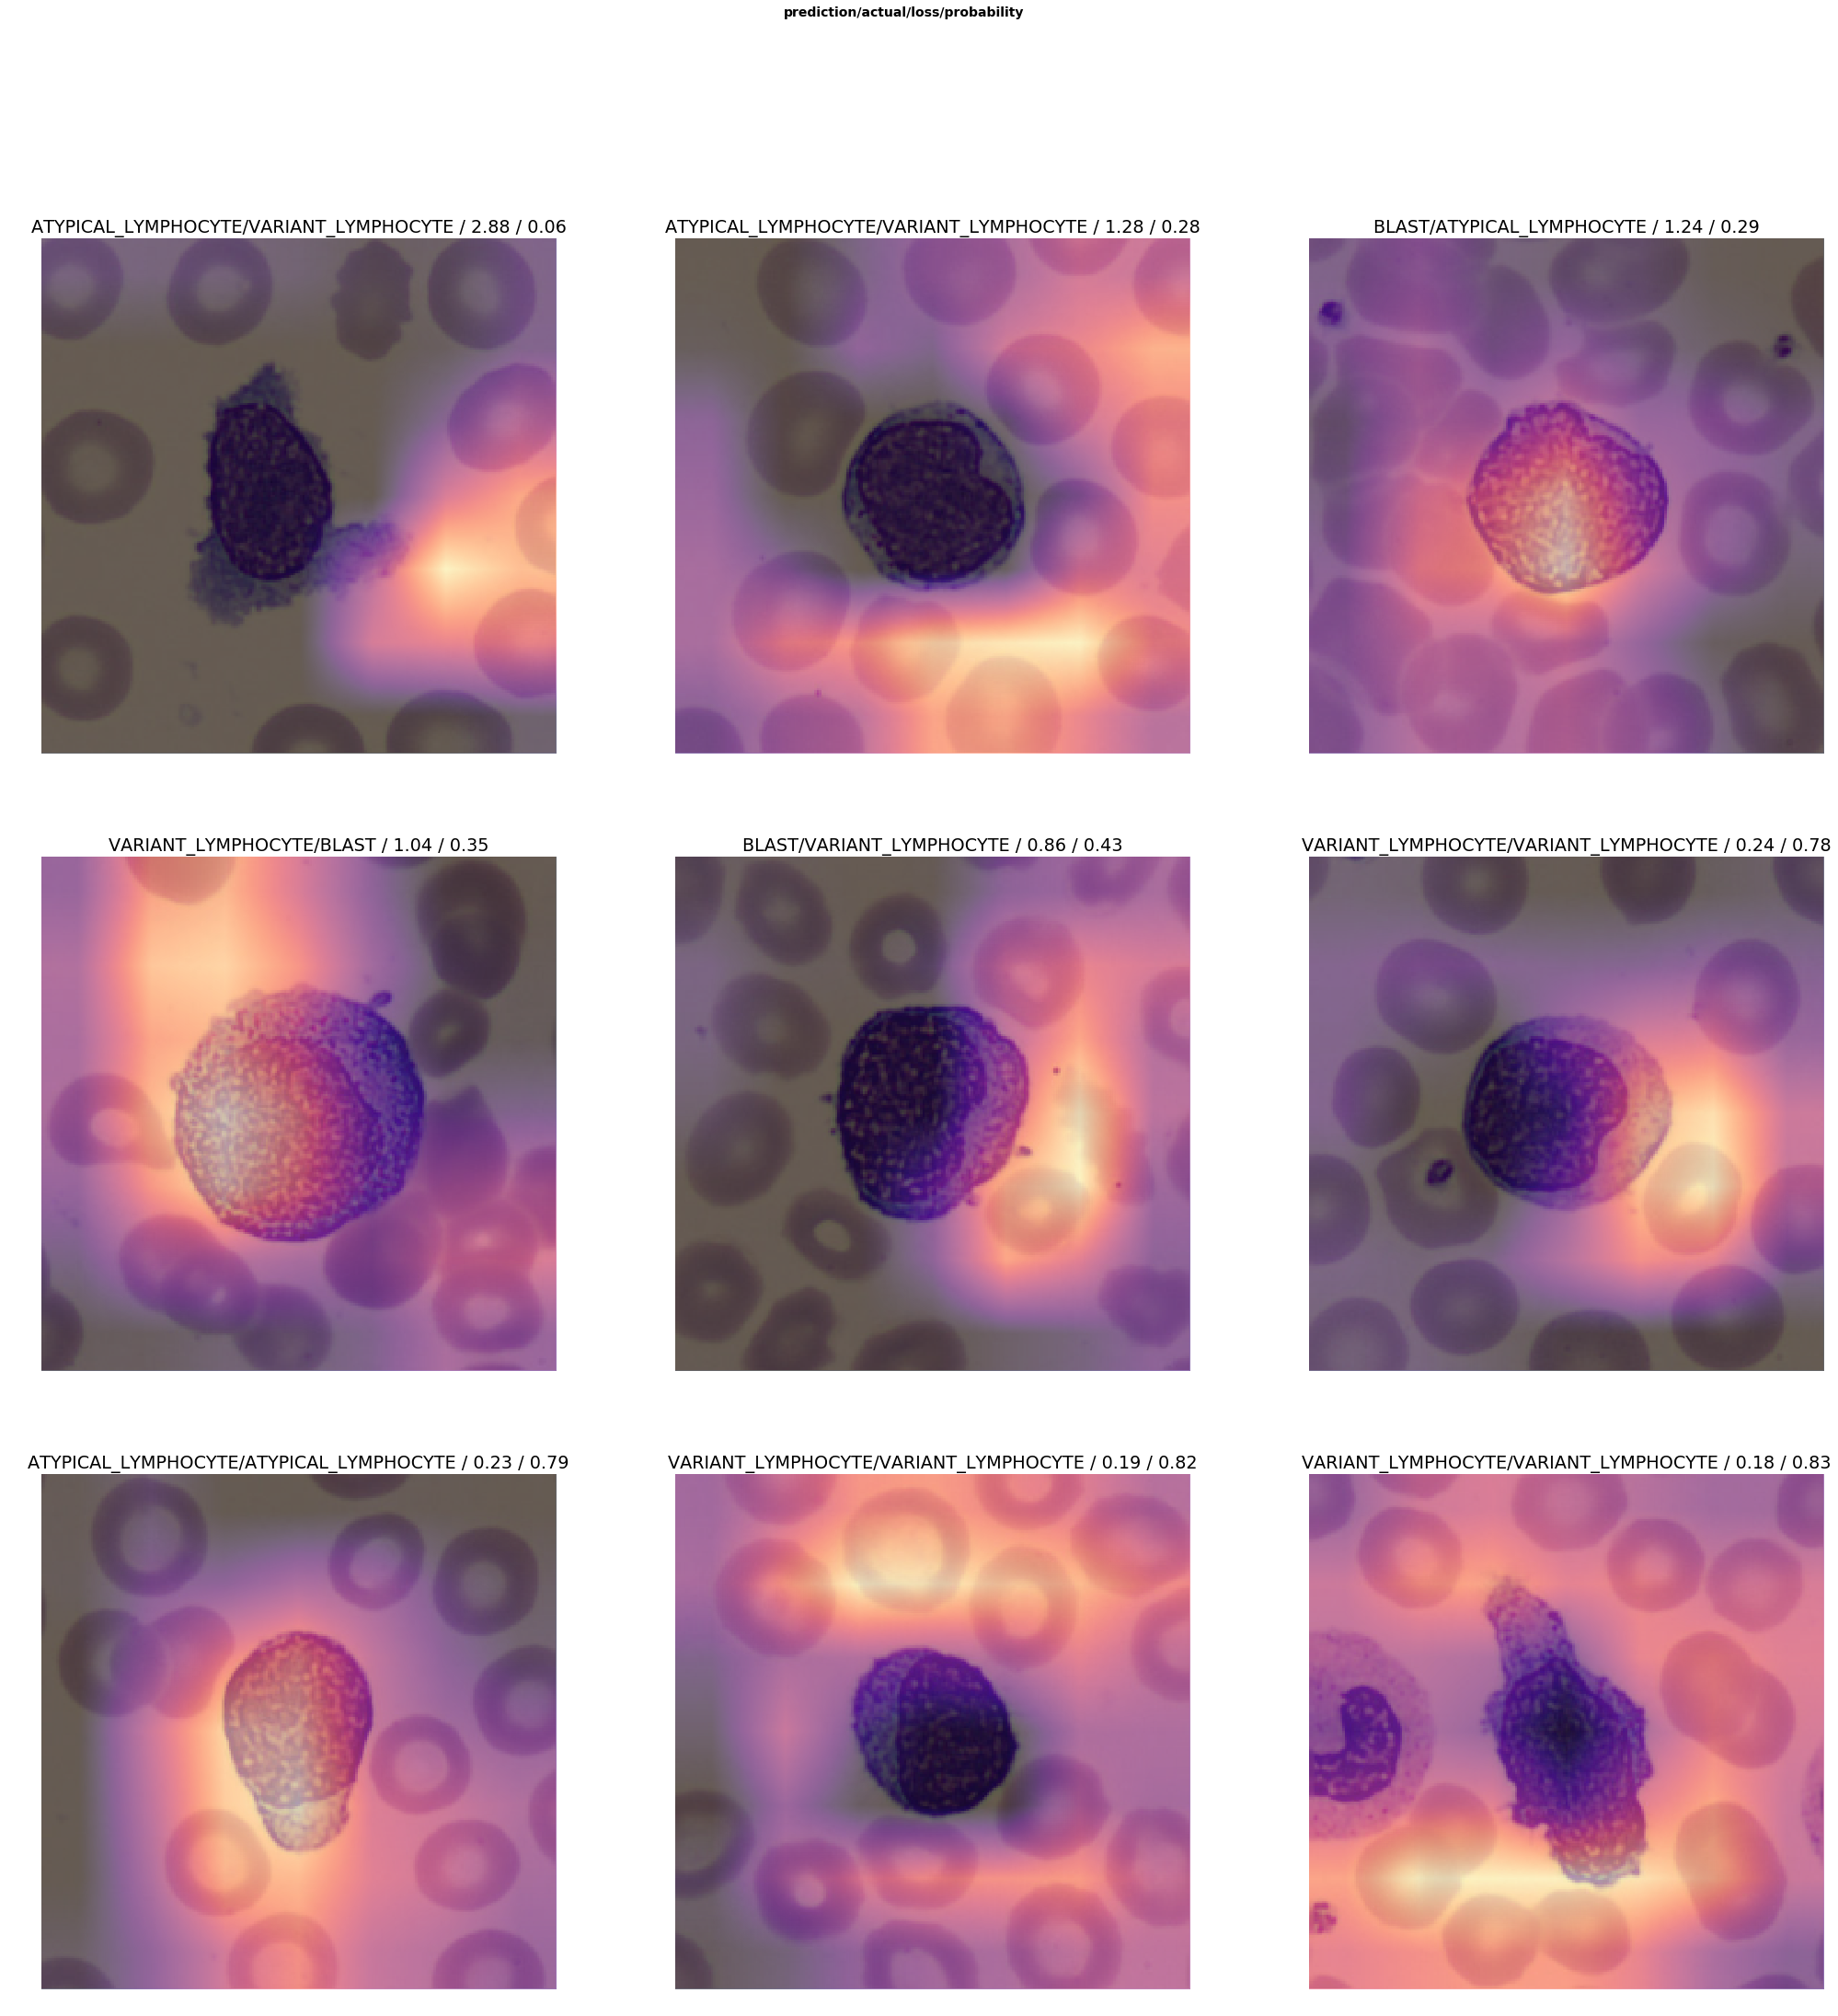

In [79]:
interp = ClassificationInterpretation.from_learner(learn_test_focal)
losses,idxs = interp.top_losses()
interp.plot_top_losses(9, largest=True, figsize=(35,35), heatmap=True)


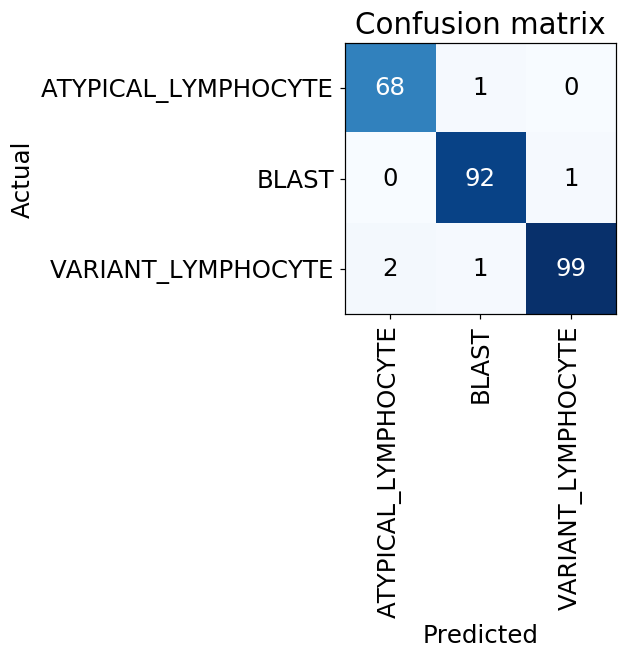

In [76]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=110)



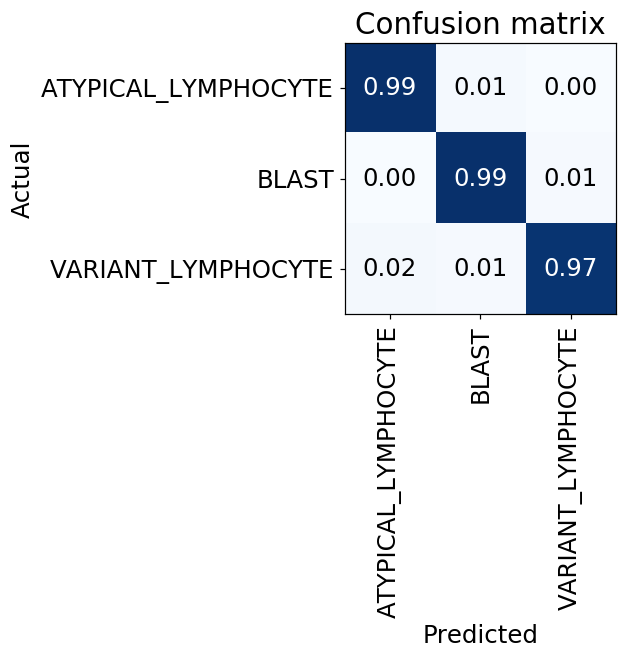

In [77]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=110, normalize=True)

In [78]:
len(data_test.valid_ds)==len(losses)==len(idxs)

True